In [193]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# For acquisition function
from scipy.stats import norm

In [194]:
# black-box function (unknown to you)
def black_box(x):
    return 1/(1+(x-1)**2) + 0.5/(1+(x-4)**2) + 0.8/(1+(x-7)**2)

In [249]:
X = np.array([[4.0],[0.0],[4.2],[3.5],[3.99],[7.43],[7.65],[7.34],[7.2],[7.69],[6.99],[10],[1.58],[2.15],[1.03],[0.8],[5.52]])
y = black_box(X.ravel())

# Scale y-values
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).ravel()

# Define kernel and GP
kernel = RBF(length_scale=0.5, length_scale_bounds=(0.2, 2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=20)

# Fit GP
gp.fit(X, y_scaled)

print("length scale:", gp.kernel_.length_scale)

length scale: 0.7036837455761343


In [250]:
# ucb acquisition function
def ucb(x, gp, beta=5.0):
    mu, sigma = gp.predict(x, return_std=True)
    return mu + beta * sigma


def expected_improvement(X, gp, y_best, xi=0.01):
   
    mu, sigma = gp.predict(X, return_std=True)
    sigma = sigma.reshape(-1, 1)
    mu = mu.reshape(-1, 1)

    # avoid division by zero
    sigma = np.maximum(sigma, 1e-9)

    imp = mu - y_best - xi
    Z = imp / sigma

    ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
    return ei.ravel()


maximum of acquisition function: 0.0000 at x = 9.0991


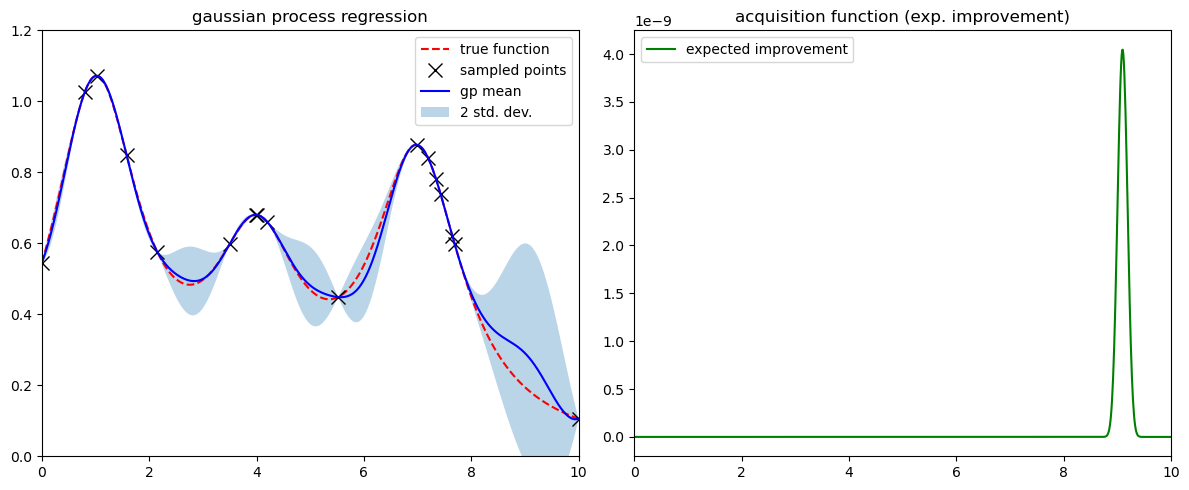

In [251]:
x_grid = np.linspace(0, 10, 1000).reshape(-1, 1)

# true function (unknown to you)
y_true = np.array([black_box(xx[0]) for xx in x_grid])

# gaussian process prediction
y_pred, sigma = gp.predict(x_grid, return_std=True)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
sigma = sigma * scaler.scale_[0]  # rescale sigma back

# evaluation of acquisition function (ucb)
#acq = ucb(x_grid, gp)
#best_idx = np.argmax(acq)
#x_next = x_grid[best_idx, 0]
#ucb_max = acq[best_idx]

# best observed value so far (in original space)
y_best = np.max(y)

# evaluate acquisition function (EI from skopt)
acq = expected_improvement(x_grid, gp, y_best, xi=1)
best_idx = np.argmax(acq)
x_next = x_grid[best_idx, 0]
ei_max = acq[best_idx]

print(f"maximum of acquisition function: {ei_max:.4f} at x = {x_next:.4f}")

# plot gpr
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_grid, y_true, "r--", label="true function")
plt.plot(X, y, "kx", markersize=10, label="sampled points")
plt.plot(x_grid, y_pred, "b", label="gp mean")
plt.fill_between(
    x_grid.ravel(),
    y_pred - 2 * sigma,
    y_pred + 2 * sigma,
    alpha = 0.3,
    label="2 std. dev."
)
plt.title("gaussian process regression")
plt.legend()
plt.xlim([0, 10])
plt.ylim([0, 1.2])

# plot acquisition
plt.subplot(1, 2, 2)

# ucb
#plt.plot(x_grid, acq, "g", label="ucb")
#plt.title("acquisition function (ucb)")

# ei
plt.plot(x_grid, acq, "g", label="expected improvement")
plt.title("acquisition function (exp. improvement)")

plt.legend()
plt.xlim([0, 10])

plt.tight_layout()
plt.show()